# CNN for Particle Classification

In this notebook, we train 10 layers deep CNN for particle type classification ($e^-$, $\mu^-$, and $\gamma$) using the workshop dataset.

In [1]:
from __future__ import print_function
from IPython.display import display
import torch, time
import numpy as np

In [3]:
from models import densenet

importing densenet


In [4]:
help(densenet.DenseNet)

Help on class DenseNet in module models.densenet:

class DenseNet(torch.nn.modules.module.Module)
 |  Densenet-BC model class, based on
 |  `"Densely Connected Convolutional Networks" <https://arxiv.org/pdf/1608.06993.pdf>`_
 |  
 |  Args:
 |      growth_rate (int) - how many filters to add each layer (`k` in paper)
 |      block_config (list of 4 ints) - how many layers in each pooling block
 |      num_init_features (int) - the number of filters to learn in the first convolution layer
 |      bn_size (int) - multiplicative factor for number of bottle neck layers
 |        (i.e. bn_size * k features in the bottleneck layer)
 |      drop_rate (float) - dropout rate after each dense layer
 |      num_classes (int) - number of classification classes
 |  
 |  Method resolution order:
 |      DenseNet
 |      torch.nn.modules.module.Module
 |      __builtin__.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, growth_rate=32, block_config=(6, 12, 24, 16), num_input_channels=2, nu

## Defining a network
Let's define our network. The design below consists of 7 convolution layers + 3 fully-connected layers (10 learnable layers). Here is a summary of the graph operations.
* Feature extractor:
    1. Input shape: (N,88,168,2) ... N samples of 88x168 2D images with 2 channels
    2. Convolution layer + ReLU, 16 filters, kernel size 3x3, stride 1 (default)
    3. 2D max-pooling, kernel size 2, stride 2
    4. 2x Convolution layer + ReLU, 32 filters, kernel size 3x3, stride 1 (default)
    5. 2D max-pooling, kernel size 2, stride 2
    6. 2x Convolution layer + ReLU, 64 filters, kernel size 3x3, stride 1 (default)
    7. 2D max-pooling, kernel size 2, stride 2
    8. 2x Convolution layer + ReLU, 128 filters, kernel size 3x3, stride 1 (default)
* Flattening
    9. 2D average-pooling, kernel size = 2D image spatial dimension at this point (results in length 128 1D array)
* Classifier:
    10. Fully-connected layer + ReLU, 128 filters
    11. Fully-connected layer + ReLU, 128 filters
    12. Fully-connected layer, M filters where M = number of classification categories

class CNN(torch.nn.Module):
    
    def __init__(self, num_class):
        
        super(CNN, self).__init__()
        # feature extractor CNN
        self._feature = torch.nn.Sequential(
            torch.nn.Conv2d(2,16,3), torch.nn.ReLU(),
            torch.nn.MaxPool2d(2,2),
            torch.nn.Conv2d(16,32,3), torch.nn.ReLU(),
            torch.nn.Conv2d(32,32,3), torch.nn.ReLU(),
            torch.nn.MaxPool2d(2,2),
            torch.nn.Conv2d(32,64,3), torch.nn.ReLU(),
            torch.nn.Conv2d(64,64,3), torch.nn.ReLU(),
            torch.nn.MaxPool2d(2,2),
            torch.nn.Conv2d(64,128,3), torch.nn.ReLU(),
            torch.nn.Conv2d(128,128,3), torch.nn.ReLU())
        self._classifier = torch.nn.Sequential(
            torch.nn.Linear(128,128), torch.nn.ReLU(),
            torch.nn.Linear(128,128), torch.nn.ReLU(),
            torch.nn.Linear(128,num_class)
        )

    def forward(self, x):
        net = self._feature(x)
        net = torch.nn.AvgPool2d(net.size()[2:])(net)
        return self._classifier(net.view(-1,128))


## Defining a train loop
For convenience, define a _BLOB_ class to keep objects together. To a BLOB instance, we attach LeNet, our loss function (`nn.CrossEntropyLoss`), and Adam optimizer algorithm. For analysis purpose, we also include `nn.Softmax`. Finally, we attach data and label place holders.

In [5]:
class BLOB:
    pass
blob=BLOB()
blob.net       = densenet.DenseNet(num_classes=3,num_input_channels=38).cuda() #CNN(3).cuda() # construct Lenet for 3 class classification, use GPU
blob.criterion = torch.nn.CrossEntropyLoss() # use softmax loss to define an error
blob.optimizer = torch.optim.Adam(blob.net.parameters()) # use Adam optimizer algorithm
blob.softmax   = torch.nn.Softmax(dim=1) # not for training, but softmax score for each class
blob.data      = None # data for training/analysis
blob.label     = None # label for training/analysis

We define 2 functions to be called in the training loop: forward and backward. These functions implement the evaluation of the results, error (loss) definition, and propagation of errors (gradients) back to update the network parameters.

In [6]:
def forward(blob,train=True):
    """
       Args: blob should have attributes, net, criterion, softmax, data, label
       Returns: a dictionary of predicted labels, softmax, loss, and accuracy
    """
    with torch.set_grad_enabled(train):
        # Prediction
        data = torch.as_tensor(blob.data).cuda()#[torch.as_tensor(d).cuda() for d in blob.data]
        #print("this is the data size before permuting: {}".format(data.size()))
        data = data.permute(0,3,1,2)
        #print("this is the data size after permuting: {}".format(data.size()))
        prediction = blob.net(data)
        # Training
        loss,acc=-1,-1
        if blob.label is not None:
            label = torch.as_tensor(blob.label).type(torch.LongTensor).cuda()#[torch.as_tensor(l).cuda() for l in blob.label]
            label.requires_grad = False
            loss = blob.criterion(prediction,label)
        blob.loss = loss
        
        softmax    = blob.softmax(prediction).cpu().detach().numpy()
        prediction = torch.argmax(prediction,dim=-1)
        accuracy   = (prediction == label).sum().item() / float(prediction.nelement())        
        prediction = prediction.cpu().detach().numpy()
        
        return {'prediction' : prediction,
                'softmax'    : softmax,
                'loss'       : loss.cpu().detach().item(),
                'accuracy'   : accuracy}

def backward(blob):
    blob.optimizer.zero_grad()  # Reset gradients accumulation
    blob.loss.backward()
    blob.optimizer.step()


## Running a train loop 
Let's prepare the data loaders for both train and test datasets. We use the latter to check if the network suffers from overtraining.

In [8]:
# Create data loader
from iotools import loader_factory
DATA_DIRS=['/data/hkml_data/IWCDmPMT/fixed/R0cm/e-','/data/hkml_data/IWCDmPMT/fixed/R0cm/mu-','/data/hkml_data/IWCDmPMT/fixed/R0cm/gamma']
# for train
train_loader=loader_factory('H5Dataset', batch_size=64, shuffle=True, num_workers=4, data_dirs=DATA_DIRS, flavour='100k.h5', start_fraction=0.0, use_fraction=0.8)
# for validation
val_loader=loader_factory('H5Dataset', batch_size=1000, shuffle=True, num_workers=2, data_dirs=DATA_DIRS, flavour='100k.h5', start_fraction=0.8, use_fraction=0.1)
# for final analysis
test_loader=loader_factory('H5Dataset', batch_size=1024, shuffle=True, num_workers=2, data_dirs=DATA_DIRS, flavour='100k.h5', start_fraction=0.9, use_fraction=0.1)

I found the following files: ['/data/hkml_data/IWCDmPMT/fixed/R0cm/e-/IWCDmPMT_e-_200MeV_R0cm_100k.h5', '/data/hkml_data/IWCDmPMT/fixed/R0cm/mu-/IWCDmPMT_mu-_200MeV_R0cm_100k.h5', '/data/hkml_data/IWCDmPMT/fixed/R0cm/gamma/IWCDmPMT_gamma_200MeV_R0cm_100k.h5']
I found the following files: ['/data/hkml_data/IWCDmPMT/fixed/R0cm/e-/IWCDmPMT_e-_200MeV_R0cm_100k.h5', '/data/hkml_data/IWCDmPMT/fixed/R0cm/mu-/IWCDmPMT_mu-_200MeV_R0cm_100k.h5', '/data/hkml_data/IWCDmPMT/fixed/R0cm/gamma/IWCDmPMT_gamma_200MeV_R0cm_100k.h5']
I found the following files: ['/data/hkml_data/IWCDmPMT/fixed/R0cm/e-/IWCDmPMT_e-_200MeV_R0cm_100k.h5', '/data/hkml_data/IWCDmPMT/fixed/R0cm/mu-/IWCDmPMT_mu-_200MeV_R0cm_100k.h5', '/data/hkml_data/IWCDmPMT/fixed/R0cm/gamma/IWCDmPMT_gamma_200MeV_R0cm_100k.h5']


Also import `CSVData` from our utility module, which lets us write train log (accuracy, loss, etc.) in a csv file.

In [7]:
# %rm log_train.csv log_val.csv

In [9]:
# Import 0) progress bar and 1) data recording utility (into csv file)
from utils import progress_bar, CSVData, disp_learn_hist, disp_train_smoothed


In [10]:
blob.train_log, blob.val_log = CSVData('log_train.csv'), CSVData('log_val.csv')

In [11]:
!date

Wed Apr 17 09:01:06 UTC 2019


In [12]:
def save_state(blob, prefix='./snapshot'):
    # Output file name
    #filename = '%s-%d.ckpt' % (prefix, blob.iteration)
    filename = '%s.ckpt' % (prefix)
    
    # Save parameters
    # 0+1) iteration counter + optimizer state => in case we want to "continue training" later
    # 2) network weight
    torch.save({
        'global_step': blob.iteration,
        'optimizer': blob.optimizer.state_dict(),
        'state_dict': blob.net.state_dict()
        }, filename)
    return filename

def restore_state(weight_file, blob):
    # Open a file in read-binary mode
    with open(weight_file, 'rb') as f:
        # torch interprets the file, then we can access using string keys
        checkpoint = torch.load(f)
        # load network weights
        blob.net.load_state_dict(checkpoint['state_dict'], strict=False)
        # if optimizer is provided, load the state of the optimizer
        if blob.optimizer is not None:
            blob.optimizer.load_state_dict(checkpoint['optimizer'])
        # load iteration count
        blob.iteration = checkpoint['global_step']

Finally, we're ready to run the training! Let's create a dataloader, write a loop to  call forward and backward.

In [13]:
#restore_state("snapshot-78600.ckpt",blob)

In [16]:
blob.iteration=None
#blob.best_val_loss=0.289653033018

In [17]:
# Define train period. "epoch" = N image consumption where N is the total number of train samples.
TRAIN_EPOCH=30.0
# Set the network to training mode
blob.net.train()
if blob.iteration is not None and blob.iteration!=0:
    iteration=blob.iteration
    epoch=iteration/len(train_loader)
    best_val_loss=blob.best_val_loss
    print("re-starting")
else:
    epoch=0.
    iteration=0
    best_val_loss=1.0e6
    print("new training")
    
# Start training


while int(epoch+0.5) < TRAIN_EPOCH:
    print('Epoch',int(epoch+0.5),'Starting @',time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()))
    # Create a progress bar for this epoch
    from utils import progress_bar
    progress = display(progress_bar(0,len(train_loader)),display_id=True)
    # Loop over data samples and into the network forward function
    for i,data in enumerate(train_loader):
        # Data and label
        blob.data,blob.label = data[0:2]
        
        
        #if i==0:
        #    print("the labels are:")
        #    print(blob.label)
        # Call forward: make a prediction & measure the average error
        res = forward(blob,True)
        # Call backward: backpropagate error and update weights
        backward(blob)
        # Epoch update
        epoch += 1./len(train_loader)
        iteration += 1
        blob.iteration=iteration
        #
        # Log/Report
        #
        # Record the current performance on train set
        blob.train_log.record(['iteration','epoch','accuracy','loss'],[iteration,epoch,res['accuracy'],res['loss']])
        blob.train_log.write()
        # once in a while, report
        if i==0 or (i+1)%10 == 0:
            message = '... Iteration %d ... Epoch %1.2f ... Loss %1.3f ... Accuracy %1.3f' % (iteration,epoch,res['loss'],res['accuracy'])
            progress.update(progress_bar((i+1),len(train_loader),message))
        # more rarely, run validation
        if (i+1)%100 == 0:
            with torch.no_grad():
                blob.net.eval()
                val_data = next(iter(val_loader))
                blob.data,blob.label = val_data[0:2]
                res = forward(blob,False)
                blob.val_log.record(['iteration','epoch','accuracy','loss'],[iteration,epoch,res['accuracy'],res['loss']])
                blob.val_log.write()
                blob.val_log.flush()
                print("VAL set results: iteration: {}, epoch: {}, accuracy: {}, loss: {}".format(iteration,epoch,res['accuracy'],res['loss']))
                save_state(blob)
                if res['loss']<best_val_loss:
                    print('best validation loss so far!')
                    best_val_loss=res['loss']
                    blob.best_val_loss=best_val_loss
                    save_state(blob,'./snapshot_best_{}'.format(blob.iteration))
                
                
            blob.net.train()
        if epoch >= TRAIN_EPOCH:
            break
    message = '... Iteration %d ... Epoch %1.2f ... Loss %1.3f ... Accuracy %1.3f' % (iteration,epoch,res['loss'],res['accuracy'])
    progress.update(progress_bar((i+1),len(train_loader),message))

blob.val_log.close()
blob.train_log.close()

new training
Epoch 0 Starting @ 2019-04-17 09:02:47


VAL set results: iteration: 100, epoch: 0.0266666666667, accuracy: 0.769, loss: 0.446761786938
best validation loss so far!
VAL set results: iteration: 200, epoch: 0.0533333333333, accuracy: 0.779, loss: 0.409407734871
best validation loss so far!
VAL set results: iteration: 300, epoch: 0.08, accuracy: 0.774, loss: 0.41439846158
VAL set results: iteration: 400, epoch: 0.106666666667, accuracy: 0.73, loss: 0.497056931257
VAL set results: iteration: 500, epoch: 0.133333333333, accuracy: 0.778, loss: 0.406725823879
best validation loss so far!
VAL set results: iteration: 600, epoch: 0.16, accuracy: 0.789, loss: 0.40891072154
VAL set results: iteration: 700, epoch: 0.186666666667, accuracy: 0.783, loss: 0.423760265112
VAL set results: iteration: 800, epoch: 0.213333333333, accuracy: 0.807, loss: 0.38495361805
best validation loss so far!
VAL set results: iteration: 900, epoch: 0.24, accuracy: 0.81, loss: 0.372883111238
best validation loss so far!
VAL set results: iteration: 1000, epoch: 0

VAL set results: iteration: 3850, epoch: 1.02666666667, accuracy: 0.807, loss: 0.370886981487
VAL set results: iteration: 3950, epoch: 1.05333333333, accuracy: 0.787, loss: 0.431787341833
VAL set results: iteration: 4050, epoch: 1.08, accuracy: 0.817, loss: 0.370082616806
VAL set results: iteration: 4150, epoch: 1.10666666667, accuracy: 0.814, loss: 0.372646152973
VAL set results: iteration: 4250, epoch: 1.13333333333, accuracy: 0.796, loss: 0.381369382143
VAL set results: iteration: 4350, epoch: 1.16, accuracy: 0.802, loss: 0.387783586979
VAL set results: iteration: 4450, epoch: 1.18666666667, accuracy: 0.795, loss: 0.388510257006
VAL set results: iteration: 4550, epoch: 1.21333333333, accuracy: 0.776, loss: 0.425034999847
VAL set results: iteration: 4650, epoch: 1.24, accuracy: 0.814, loss: 0.352738946676
VAL set results: iteration: 4750, epoch: 1.26666666667, accuracy: 0.824, loss: 0.351481109858
VAL set results: iteration: 4850, epoch: 1.29333333333, accuracy: 0.807, loss: 0.366912

VAL set results: iteration: 7600, epoch: 2.02666666667, accuracy: 0.813, loss: 0.379615694284
VAL set results: iteration: 7700, epoch: 2.05333333333, accuracy: 0.789, loss: 0.404213041067
VAL set results: iteration: 7800, epoch: 2.08, accuracy: 0.773, loss: 0.409512370825
VAL set results: iteration: 7900, epoch: 2.10666666667, accuracy: 0.811, loss: 0.387672990561
VAL set results: iteration: 8000, epoch: 2.13333333333, accuracy: 0.802, loss: 0.376831620932
VAL set results: iteration: 8100, epoch: 2.16, accuracy: 0.819, loss: 0.365715354681
VAL set results: iteration: 8200, epoch: 2.18666666667, accuracy: 0.793, loss: 0.421699553728
VAL set results: iteration: 8300, epoch: 2.21333333333, accuracy: 0.83, loss: 0.34687307477
best validation loss so far!
VAL set results: iteration: 8400, epoch: 2.24, accuracy: 0.82, loss: 0.371771603823
VAL set results: iteration: 8500, epoch: 2.26666666667, accuracy: 0.819, loss: 0.364911198616
VAL set results: iteration: 8600, epoch: 2.29333333333, accur

VAL set results: iteration: 11350, epoch: 3.02666666667, accuracy: 0.818, loss: 0.356466084719
VAL set results: iteration: 11450, epoch: 3.05333333333, accuracy: 0.814, loss: 0.375598162413
VAL set results: iteration: 11550, epoch: 3.08, accuracy: 0.808, loss: 0.381444603205
VAL set results: iteration: 11650, epoch: 3.10666666667, accuracy: 0.824, loss: 0.377156347036
VAL set results: iteration: 11750, epoch: 3.13333333333, accuracy: 0.796, loss: 0.398789554834
VAL set results: iteration: 11850, epoch: 3.16, accuracy: 0.821, loss: 0.358617097139
VAL set results: iteration: 11950, epoch: 3.18666666667, accuracy: 0.803, loss: 0.369330048561
VAL set results: iteration: 12050, epoch: 3.21333333333, accuracy: 0.832, loss: 0.343524336815
VAL set results: iteration: 12150, epoch: 3.24, accuracy: 0.802, loss: 0.372585952282
VAL set results: iteration: 12250, epoch: 3.26666666667, accuracy: 0.827, loss: 0.357794761658
VAL set results: iteration: 12350, epoch: 3.29333333333, accuracy: 0.823, los

VAL set results: iteration: 15100, epoch: 4.02666666667, accuracy: 0.818, loss: 0.391641050577
VAL set results: iteration: 15200, epoch: 4.05333333333, accuracy: 0.8, loss: 0.405079126358
VAL set results: iteration: 15300, epoch: 4.08, accuracy: 0.82, loss: 0.372014462948
VAL set results: iteration: 15400, epoch: 4.10666666667, accuracy: 0.789, loss: 0.397746562958
VAL set results: iteration: 15500, epoch: 4.13333333333, accuracy: 0.826, loss: 0.383771181107
VAL set results: iteration: 15600, epoch: 4.16, accuracy: 0.829, loss: 0.380101978779
VAL set results: iteration: 15700, epoch: 4.18666666667, accuracy: 0.799, loss: 0.404690861702
VAL set results: iteration: 15800, epoch: 4.21333333333, accuracy: 0.794, loss: 0.394644081593
VAL set results: iteration: 15900, epoch: 4.24, accuracy: 0.809, loss: 0.395931005478
VAL set results: iteration: 16000, epoch: 4.26666666667, accuracy: 0.837, loss: 0.367994636297
VAL set results: iteration: 16100, epoch: 4.29333333333, accuracy: 0.81, loss: 0

VAL set results: iteration: 18850, epoch: 5.02666666667, accuracy: 0.794, loss: 0.415848761797
VAL set results: iteration: 18950, epoch: 5.05333333333, accuracy: 0.807, loss: 0.395903646946
VAL set results: iteration: 19050, epoch: 5.08, accuracy: 0.787, loss: 0.442774653435
VAL set results: iteration: 19150, epoch: 5.10666666667, accuracy: 0.794, loss: 0.433836877346
VAL set results: iteration: 19250, epoch: 5.13333333333, accuracy: 0.809, loss: 0.428458154202
VAL set results: iteration: 19350, epoch: 5.16, accuracy: 0.764, loss: 0.481369286776
VAL set results: iteration: 19450, epoch: 5.18666666667, accuracy: 0.801, loss: 0.443327486515
VAL set results: iteration: 19550, epoch: 5.21333333333, accuracy: 0.777, loss: 0.465516060591
VAL set results: iteration: 19650, epoch: 5.24, accuracy: 0.799, loss: 0.403520226479
VAL set results: iteration: 19750, epoch: 5.26666666667, accuracy: 0.818, loss: 0.382308214903
VAL set results: iteration: 19850, epoch: 5.29333333333, accuracy: 0.828, los

VAL set results: iteration: 22600, epoch: 6.02666666667, accuracy: 0.796, loss: 0.441488921642
VAL set results: iteration: 22700, epoch: 6.05333333333, accuracy: 0.803, loss: 0.424186140299
VAL set results: iteration: 22800, epoch: 6.08, accuracy: 0.793, loss: 0.439218193293
VAL set results: iteration: 22900, epoch: 6.10666666667, accuracy: 0.799, loss: 0.435931742191
VAL set results: iteration: 23000, epoch: 6.13333333333, accuracy: 0.784, loss: 0.442783176899
VAL set results: iteration: 23100, epoch: 6.16, accuracy: 0.792, loss: 0.430132776499
VAL set results: iteration: 23200, epoch: 6.18666666667, accuracy: 0.781, loss: 0.48061260581
VAL set results: iteration: 23300, epoch: 6.21333333333, accuracy: 0.799, loss: 0.429002374411
VAL set results: iteration: 23400, epoch: 6.24, accuracy: 0.796, loss: 0.437011361122
VAL set results: iteration: 23500, epoch: 6.26666666667, accuracy: 0.802, loss: 0.430431902409
VAL set results: iteration: 23600, epoch: 6.29333333333, accuracy: 0.808, loss

VAL set results: iteration: 26350, epoch: 7.02666666667, accuracy: 0.785, loss: 0.485080599785
VAL set results: iteration: 26450, epoch: 7.05333333333, accuracy: 0.786, loss: 0.498941123486
VAL set results: iteration: 26550, epoch: 7.08, accuracy: 0.79, loss: 0.454534113407
VAL set results: iteration: 26650, epoch: 7.10666666667, accuracy: 0.783, loss: 0.496529608965
VAL set results: iteration: 26750, epoch: 7.13333333333, accuracy: 0.77, loss: 0.556774258614
VAL set results: iteration: 26850, epoch: 7.16, accuracy: 0.802, loss: 0.44840657711
VAL set results: iteration: 26950, epoch: 7.18666666667, accuracy: 0.768, loss: 0.497467368841
VAL set results: iteration: 27050, epoch: 7.21333333333, accuracy: 0.792, loss: 0.494547396898
VAL set results: iteration: 27150, epoch: 7.24, accuracy: 0.789, loss: 0.474315822124
VAL set results: iteration: 27250, epoch: 7.26666666667, accuracy: 0.8, loss: 0.442265659571
VAL set results: iteration: 27350, epoch: 7.29333333333, accuracy: 0.796, loss: 0.

VAL set results: iteration: 30100, epoch: 8.02666666667, accuracy: 0.814, loss: 0.445481479168
VAL set results: iteration: 30200, epoch: 8.05333333333, accuracy: 0.782, loss: 0.57302904129
VAL set results: iteration: 30300, epoch: 8.08, accuracy: 0.787, loss: 0.505223870277
VAL set results: iteration: 30400, epoch: 8.10666666667, accuracy: 0.777, loss: 0.490198165178
VAL set results: iteration: 30500, epoch: 8.13333333333, accuracy: 0.786, loss: 0.487457156181
VAL set results: iteration: 30600, epoch: 8.16, accuracy: 0.773, loss: 0.477845549583
VAL set results: iteration: 30700, epoch: 8.18666666667, accuracy: 0.804, loss: 0.51612919569
VAL set results: iteration: 30800, epoch: 8.21333333333, accuracy: 0.79, loss: 0.488574624062
VAL set results: iteration: 30900, epoch: 8.24, accuracy: 0.784, loss: 0.53203856945


KeyboardInterrupt: 

## Inspecting the training process
Let's plot the train log for both train and test set.

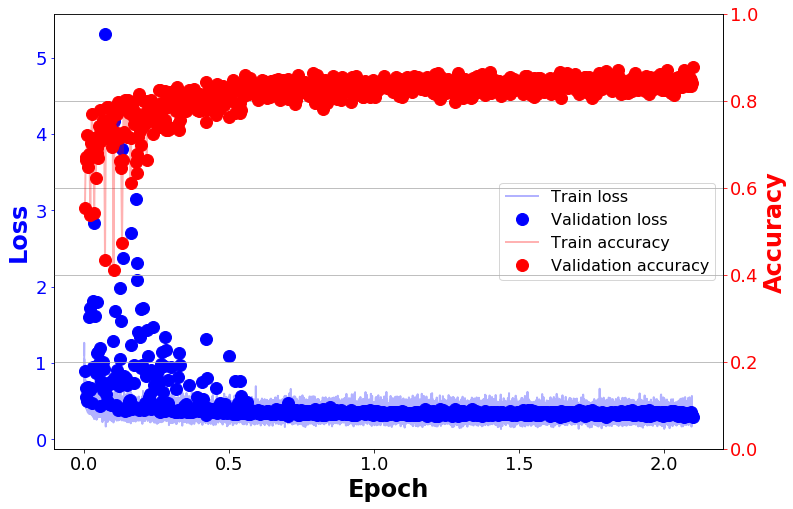

In [12]:
disp_learn_hist(blob.train_log, blob.val_log)

We see the loss is coming down while the accuracy is increasing. These two should be anti-correlated, so this is expected. We also see the network performance on the test dataset (circles) follow those of train dataset (lines). This means there is no apparent overtraining.

**Question: is the network still learning?**
Both the loss and accuracy curve have large fluctuations and it is somewhat hard to see if the values are still changing. Let's plot the moving average of the loss and accuracy values.

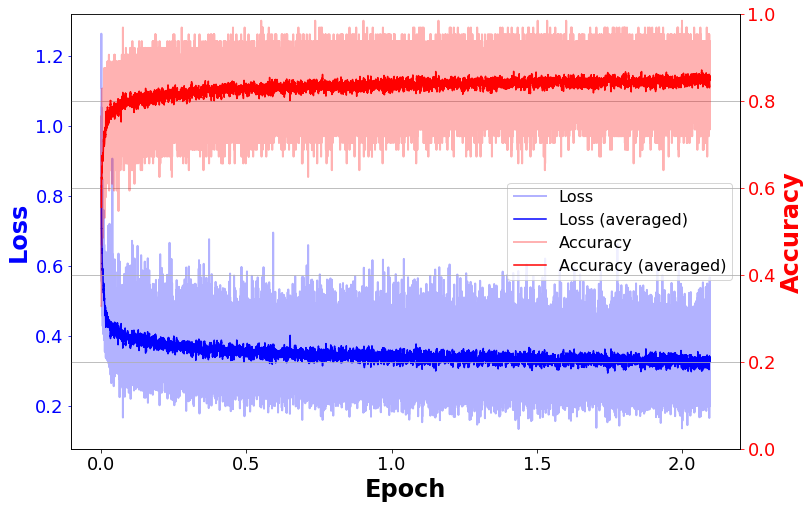

In [13]:
disp_train_smoothed(blob.train_log, blob.val_log)

The tick lines now represent the moving average (all data points are from the train log). It appears the network is still learning. We can train for a longer period to achieve a better accuracy.

## Performance Analysis
Beyond looking at the performance of the network, we can analyze how the network is performing for each classification target. Let's first obtain a high-statistics analysis output by running the network on all test samples.

First load the stored model

In [14]:
restore_state("snapshot_best-61500.ckpt",blob)

In [18]:
# blob.data,blob.label = next(iter(test_loader))[0:2]

In [19]:
# res=forward(blob,False)

In [15]:
def inference(blob,data_loader):
    label,prediction,accuracy=[],[],[]
    # set the network to test (non-train) mode
    blob.net.eval()
    # create the result holder
    index,label,prediction = [],[],[]
    for i,data in enumerate(data_loader):
        if i%10==0:
            print("iteration {}".format(i))
        blob.data, blob.label = data[0:2]
        res = forward(blob,False)
        accuracy.append(res['accuracy'])
        prediction.append(res['prediction'])
        label.append(blob.label)
        #if i==2: break
    # report accuracy
    accuracy   = np.array(accuracy,dtype=np.float32)
    label      = np.hstack(label)
    prediction = np.hstack(prediction)
    
    return accuracy, label, prediction

Let's run the inference using this function on the test sample, and look at the error matrix.

iteration 0
iteration 10
iteration 20
iteration 30
iteration 40
iteration 50
iteration 60
iteration 70
iteration 80
iteration 90
iteration 100
iteration 110
iteration 120
iteration 130
iteration 140
iteration 150
iteration 160
iteration 170
iteration 180
iteration 190
iteration 200
iteration 210
iteration 220
iteration 230
iteration 240
iteration 250
iteration 260
iteration 270
iteration 280
iteration 290
Accuracy mean 0.8434553 std 0.0116968425


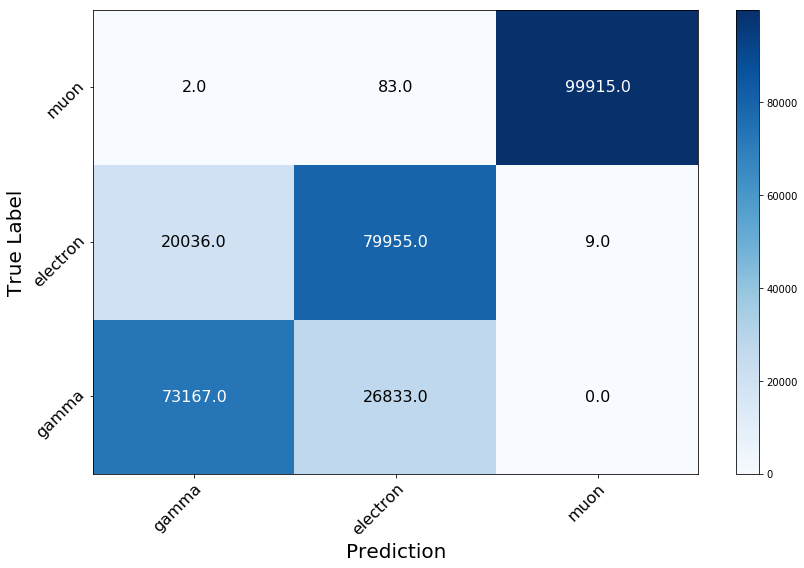

In [16]:
from utils import plot_confusion_matrix
accuracy,label,prediction = inference(blob,test_loader)
print('Accuracy mean',accuracy.mean(),'std',accuracy.std())
plot_confusion_matrix(label,prediction,['gamma','electron','muon'])

As one may expect, muon is distinguished fairly well while there is some confusion between electron and gamma ray.